In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sb
import re

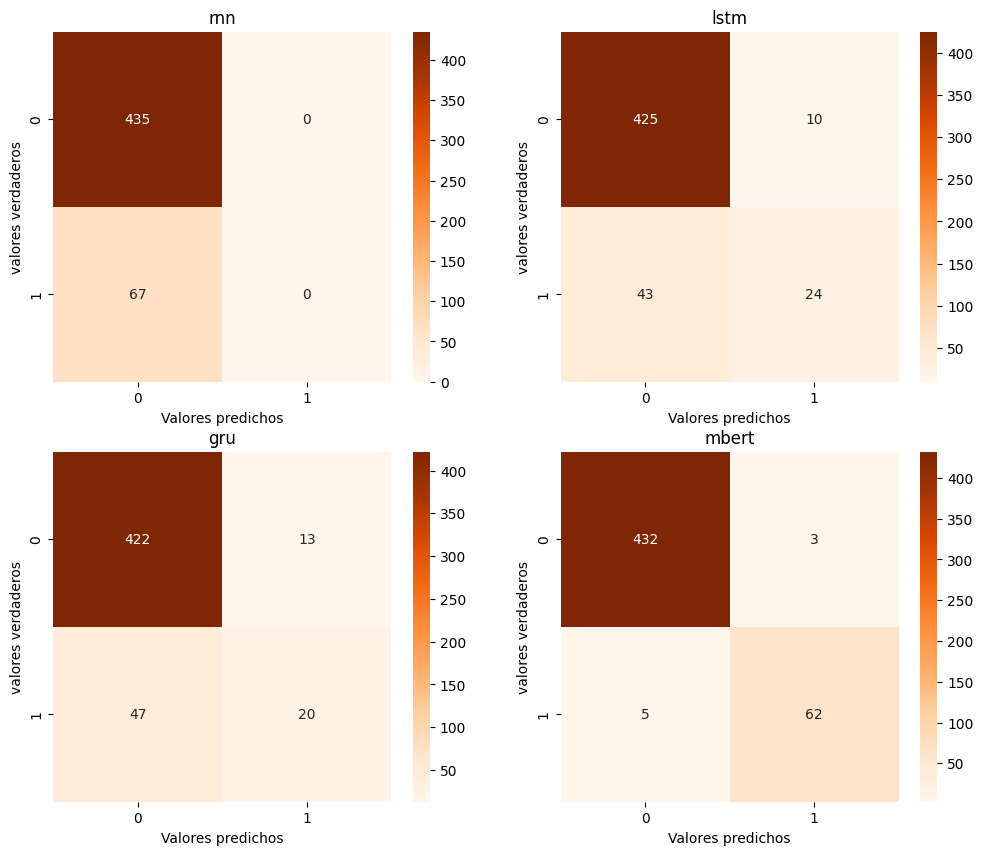

In [4]:
models=[["rnn_se20230624-131214","lstm_se20230624-133114"],["gru_se20230624-133632","mbert-20230625-010030"]]
fig, axes = plt.subplots(2,2)
fig.set_size_inches(12, 10)
for i in [0,1]:
    for j in [0,1]:
        model=models[i][j]
        yv_pred=np.loadtxt("logs/fit/"+model+"/yv_pred.csv",delimiter=";",skiprows=1)
        yv=np.loadtxt("logs/fit/"+model+"/yv.csv",delimiter=";",skiprows=1)
        yv=np.argmax(yv,axis=1)
        yv_pred=np.argmax(yv_pred,axis=1)
        matriz = confusion_matrix(yv, yv_pred)
        ax=axes[i][j]
        sb.heatmap(matriz, annot=True, ax = ax, cmap="Oranges",fmt="d");
        ax.set_xlabel('Valores predichos');ax.set_ylabel('valores verdaderos'); 
        ax.set_title(re.split("(_|-)+",model)[0]);

In [3]:
x_val=np.loadtxt("base_x_val.csv",delimiter="\t",skiprows=0,dtype="str",encoding="utf-8")
x_val=x_val[:,1]
features=["message"]
df=pd.DataFrame(x_val,columns=features)
df["y"]=yv
df["yp"]=yv_pred

In [4]:
df[(df["y"]==1) & (df["yp"]==0)]

,message,y,yp
35,Goal Arsenal 4 Henry 7 v Liverpool 2 Henry sco...,1,0
71,Did you hear about the new Divorce Barbie It c...,1,0
90,Filthy stories and GIRLS waiting for your,1,0
169,Latest News Police station toilet stolen cops ...,1,0
182,RECPT 13 You have ordered a Ringtone Your orde...,1,0


In [5]:
df[(df["y"]==0) & (df["yp"]==1)]

,message,y,yp
211,Hey pple700 or 900 for 5 nightsExcellent locat...,0,1
293,HI DARLIN I FINISH AT 3 DO U 1 2 PICK ME UP OR...,0,1
490,We are pleased to inform that your application...,0,1


In [7]:
from transformers import MobileBertTokenizer
from transformers import MobileBertForSequenceClassification
id2label={0:"NO_SPAM",1:"SPAM"}
label2id={"NO_SPAM":0,"SPAM":1}
model_name = "./models/mbert-20230625-010030--classifier"
model = MobileBertForSequenceClassification.from_pretrained(
    "./models/mbert-20230625-010030--classifier",
    label2id=label2id,
    id2label=id2label,
     num_labels=2)
tokenizer = MobileBertTokenizer.from_pretrained("google/mobilebert-uncased")

# With both the model and tokenizer initialized we are now able to get explanations on an example text.

from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

In [8]:
message=df.iloc[90]["message"]
word_attributions = cls_explainer(message)
print(word_attributions)
print(cls_explainer.predicted_class_name)
cls_explainer.visualize()

[('[CLS]', 0.0), ('filthy', 0.02767184512190632), ('stories', 0.4058141363105123), ('and', -0.03169314319188271), ('girls', 0.38326442546064243), ('waiting', 0.5785393920303148), ('for', -0.11368050501833975), ('your', -0.5822559533890688), ('[SEP]', 0.0)]
NO_SPAM


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,NO_SPAM (1.00),NO_SPAM,0.67,[CLS] filthy stories and girls waiting for your [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,NO_SPAM (1.00),NO_SPAM,0.67,[CLS] filthy stories and girls waiting for your [SEP]


In [9]:
message=df.iloc[90]["message"]
word_attributions = cls_explainer(message,class_name="SPAM")
print(word_attributions)
print(cls_explainer.predicted_class_name)
cls_explainer.visualize()

[('[CLS]', 0.0), ('filthy', -0.028148485548220296), ('stories', -0.4065112121821278), ('and', 0.033839642797119845), ('girls', -0.38586294803275395), ('waiting', -0.5839282157328721), ('for', 0.10740208598337729), ('your', 0.575685323627273), ('[SEP]', 0.0)]
NO_SPAM


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,NO_SPAM (0.00),SPAM,-0.69,[CLS] filthy stories and girls waiting for your [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,NO_SPAM (0.00),SPAM,-0.69,[CLS] filthy stories and girls waiting for your [SEP]


In [10]:
import torch

message=df.iloc[490]["message"]
inputs = tokenizer(message,
max_length=512,
truncation = True,
padding = 'max_length',
return_tensors="pt")
l = model(**inputs).logits
predicted_class_id = l.argmax().item()
model.config.id2label[predicted_class_id]

'SPAM'

In [11]:
tf_input_ids = tokenizer.encode(message)
print(tokenizer.decode(tf_input_ids))
input_ids = torch.tensor([tf_input_ids])
print(input_ids)
model_outputs = model(input_ids,output_hidden_states=True,
                                             output_attentions=True)
all_hidden_states, all_attentions =  model_outputs['hidden_states'],  model_outputs['attentions']

2024-09-04 17:59:29.785310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CLS] we are pleased to inform that your application for airtel broadband is processed successfully your installation will happen within 3 days [SEP]
tensor([[  101,  2057,  2024,  7537,  2000, 12367,  2008,  2115,  4646,  2005,
          2250,  9834, 19595,  2003, 13995,  5147,  2115,  8272,  2097,  4148,
          2306,  1017,  2420,   102]])


(24, 4, 24, 24)


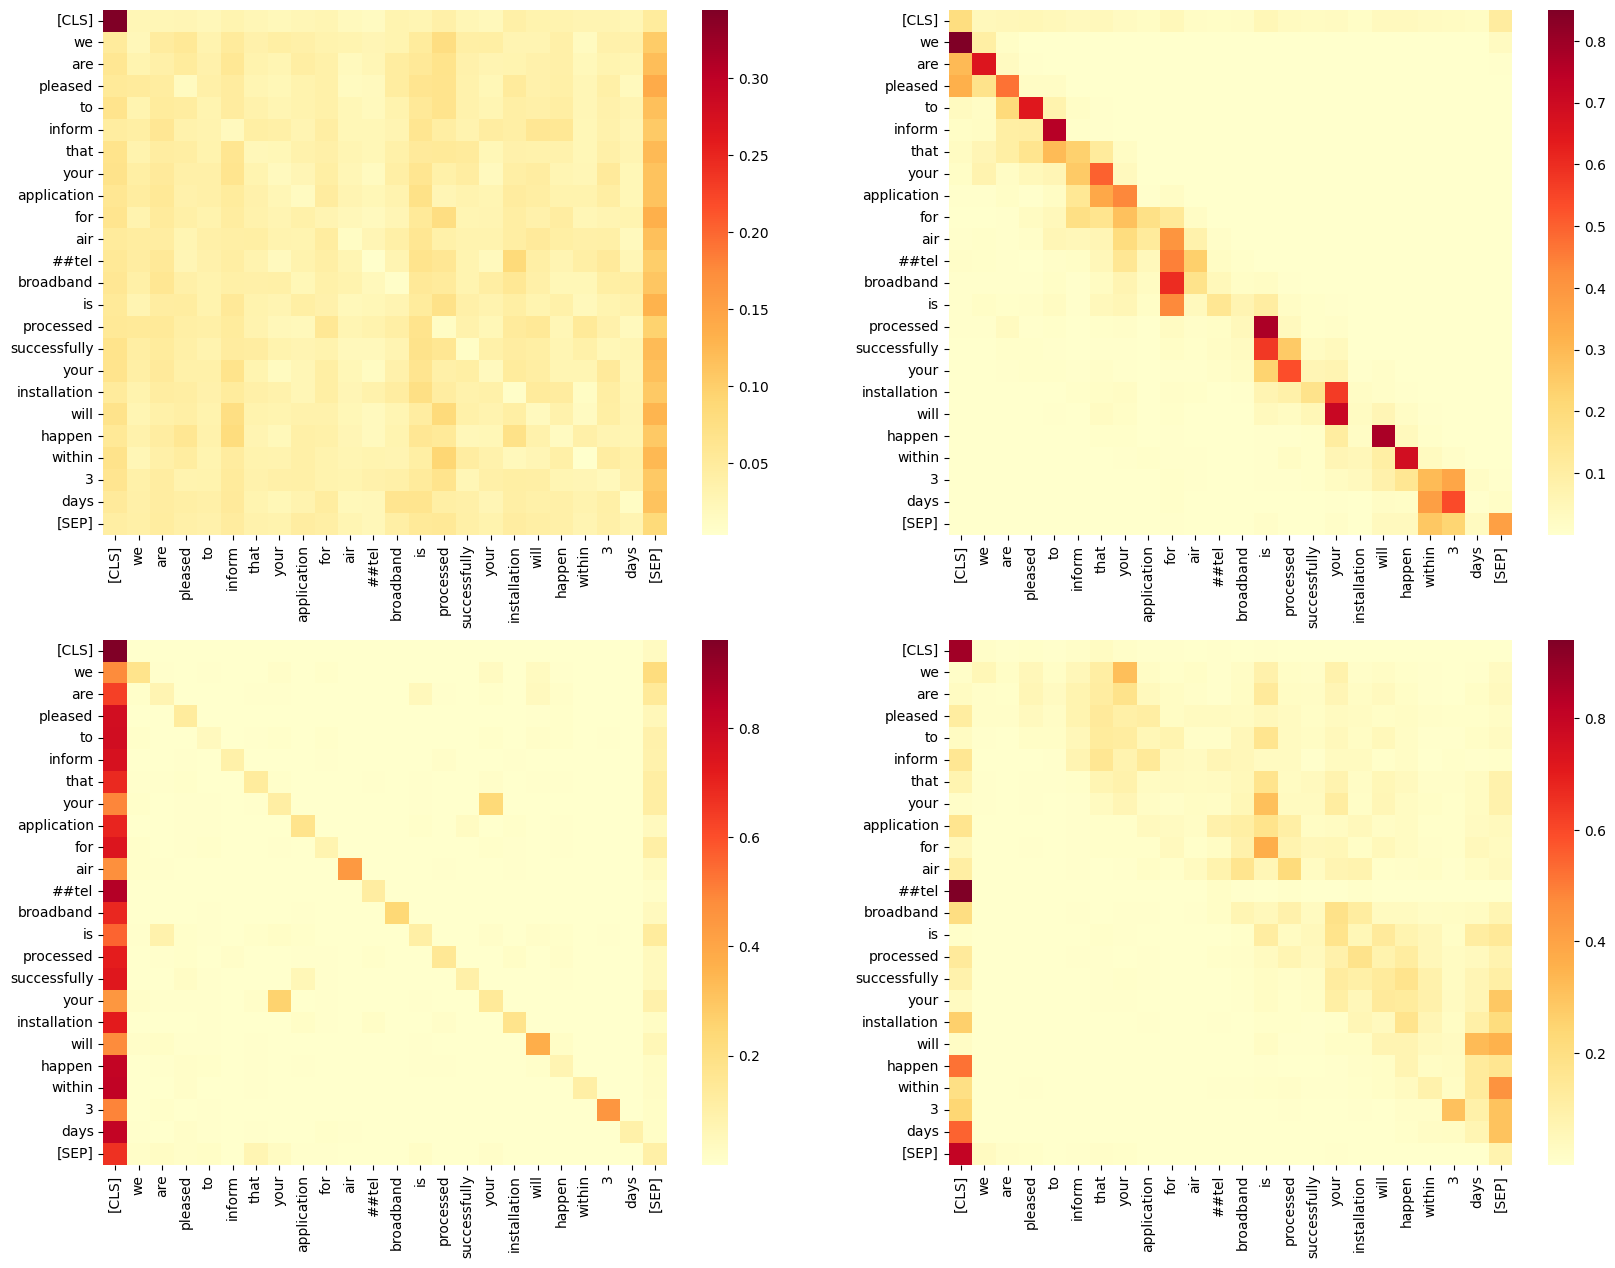

In [12]:
_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)
tokens = ['[CLS]']+tokenizer.tokenize(message)+['[SEP]']

xticklb = tokens
yticklb = tokens
figure, axis = plt.subplots(2, 2)
figure.set_figheight(15)
figure.set_figwidth(20)
for i in [0,1]:
    for j in [0,1]:
        att=attentions_mat[i,j,:,:]
        sb.heatmap(att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd",ax=axis[i][j])